## Introduction
At present there are approximately 7.7 billion people in the world with at least 3.5 billion of us online, implying that social media platforms are used by approximately one-in-three people in the world. This sudden growth and adoption has transformed the way we find partners, access news and information, or even how we organize political change and in so many other different ways. Leveraging the power of social media is now more important than ever before. This project aims to optimize social media activity for our users by providing them suggestions based on the analysis of data that we get from the Twitter API. Specifically,our project will have four key features that will provide suggestions on the following: 
    1. What the best time to post on social media would be 
    2. What are some keywords to include in a tweet based on post category and trending tweets 
    3. What are some hashtags to include in a tweet based on post category and trending tweets 
    4. What is the sentiment of the tweet the user has drafted
For this project, we will be focusing specifically on Twitter. We have developed these four features because these are the four main components of a tweet that a user should think about before posting it. We want to ensure that a user is posting their tweet when the most people are going to see it. Additionally, we want to provide the user with suggestions of content, including the words itself and the hashtags, that has shown to be popular. Finally, we also want to ensure that the content that the user inputted is reflecting the same sentiment that they are intending to express.

## Table of Contents
- [Architecture Diagram](#Architecture-Diagram)
- [Installing the Libraries](#Installing-the-Libraries)
- [User Input](#User-Input)
- [Gathering the Data](#Gathering-the-Data)
    - [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
    - [Webscraping](#Webscraping)
    - [Twitter API](#Twitter-API)
- [Finding the Best Time to Post](#Finding-the-Best-Time-to-Post)
- [Predicting Popular Keywords and Hashtags](#Predicting-Popular-Keywords-and-Hashtags)
- [Sentiment Analysis](#Sentiment-Analysis)
- [Conclusion](#Conclusion)
- [Suggestions for Future Research](#Suggestions-for-Future-Research)
- [Additional Resources](#Additional-Resources)

## Architecture Diagram

Below we have illustrated the pipeline that the data will follow. With our project, we will have the user input their username, the tweet that they intend on posting, and the category or categories of the tweet that the content of their tweet falls under. With this data, we can use the Twitter API to begin building a database of all the tweets that were posted globally that fall under the category that the user inputed. We also use webscraping to build a database of all of the tweets and posts on the users timeline. Thus, for each feature of our project we can provide two suggestions, one that is based off of the global data and one that is user specific. For our global suggestion, we will analyze all of the tweets from any Twitter user globally in the given category and give a suggestion based on the data from all Twitter users in that category. For our user specific suggestion, we will analyze all of the tweets that the user has posted and give a suggestion based on only the data from the user.

With this data, we can do a time series analysis to analyze the best time for social media engagment globally for the inputted category, as well as specifically for the user. Additionally, after we have cleaned and processed the data, we can use TFIDF to analyze the most popular keywords and hashtags for all tweets globally within the given category, as well as for all of the tweets of the user. Finally, we can use a sentiment analysis model to analyze the sentiment behind the tweet that the user intends on posting. 

<img src = "Capture.png" align = "center">

## Installing the Libraries

In order to gather the data, we will mainly be using Tweepy and the Twitter API, as well as, Selenium for webscraping. For each component of our project, we will be using different module for each component. For the time component, we will mainly be using Pandas for the time series analysis. For the keywords and hashtags, we will mainly be using the sklearn module. Finally, for the sentiment analysis, we will be using the Textblob and NLTK. 

In [31]:
import requests
import urllib
import tweepy
import json
import csv
import pandas as pd
from requests.auth import HTTPBasicAuth
import matplotlib.pyplot as plt
import re
import io
import time
from datetime import datetime
from bs4 import BeautifulSoup
import unicodedata
from unidecode import unidecode

import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
#from webdriver_manager.edge import EdgeDriverManager

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

## User Input

We will have the user input their username or Twitter handle to us for webscraping. We will also have the user input the tweet that they intend on posting for sentiment analysis. Finally, we will have the user input the category of their tweet in order to gather data on tweets that are more relevant to the tweet that the user wants to post.

In [4]:
user_name = input("What is your username? ")

What is your username? elonmusk


In [5]:
orig_tweet = input("What is your tweet? ")
#"Huge thanks to everyone who contributed ideas to Cybertruck. It’s better because of you! ♥️♥️♥️ #Tesla #Tech2020 #Design"

What is your tweet? Huge thanks to everyone who contributed ideas to Cybertruck. It’s better because of you! ♥️♥️♥️ #Tesla #Tech2020 #Design


In [6]:
#Possible Categories are: Sports", "Politics", "Entertainment", "Education", "Technology", "Business"
orig_categories = input("What is the category of your tweet? These are the possible categories: Sports, Politics, Entertainment, Education, Technology, Business. Please input the categories comma separated. ")
orig_categories = orig_categories.split(",")

What is the category of your tweet? These are the possible categories: Sports, Politics, Entertainment, Education, Technology, Business. Please input the categories comma separated. Education, Technology


##  Gathering the Data

To begin with, we need to gather our data from Twitter. We will be using the Twitter API to get all of the tweets that were posted globally in the specfic inputted category. Then, we will be using webscraping to scrape the all of the posts from the user's timeline. However, in order to use the data that we have gathered, we need to clean and preprocess the data so that we can complete our analyses.

### Data Cleaning and Preprocessing

Below, we have listed out all of the functions that we will need to use in our project in order to process and analyze our data. In order to analyze the content of the user's intended tweet, the content of global tweets, and the content of the tweets on the user's timeline, we will need to replace all characters in each tweet that are not UTF-8 with a description of the emoji, remove all all of the extremely common words, or the stopwords, and break down the tweet into tokens of it's keywords and it's hashtags.

In [13]:
### replace emojis with descriptions of the emojis 
def de_emoji(tweet):
    new_tweet = ""
    emojis = []
    for character in tweet:
        try:
            character.encode("ascii")
            new_tweet += character
        except UnicodeEncodeError:
            replaced = unidecode(str(character))
            if replaced != '' and replaced !="[?]":
                new_tweet += replaced
            else:
                try:
                    emojis.append(unicodedata.name(character))
                except ValueError:
                     new_tweet += "[x]"
    return new_tweet, ",".join(emojis)
orig_tweet, orig_emojis = de_emoji(orig_tweet)
print("Tweet without emojis: "+orig_tweet+"\n")
print("Description of Emojis Used: "+orig_emojis)

Tweet without emojis: Huge thanks to everyone who contributed ideas to Cybertruck. It's better because of you!  #Tesla #Tech2020 #Design

Description of Emojis Used: BLACK HEART SUIT,VARIATION SELECTOR-16,BLACK HEART SUIT,VARIATION SELECTOR-16,BLACK HEART SUIT,VARIATION SELECTOR-16


In [14]:
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
def preprocess(tweet):
    
    ## lowercase
    lower_case = tweet.lower()
    lower_case= re.sub("'s", "", lower_case)
    
    ## removing apostrophes
    lower_case = lower_case.translate(str.maketrans('', '', "'"))
    lower_case = lower_case.translate(str.maketrans('', '', '"'))
    
    ## remove links from tweets
    lower_case= re.sub("(http://t.co/[a-zA-Z0-9]{10})+", ",,", lower_case) 
    lower_case= re.sub("(https://t.co/[a-zA-Z0-9]{10})+", ",,", lower_case) 
    lower_case= re.sub("(.com)+", ",,", lower_case) 
    lower_case= re.sub("(.co)+", ",,", lower_case) 
    ## removing punctuation, only considering alphanumeric characters
    tweet_list = re.split('[^a-zA-Z0-9]', lower_case)
    
    str_list = [x for x in tweet_list if x != '']
    
    ## lemmatizing each word
    str_list = [lemmatizer.lemmatize(x) for x in str_list]
    
    ## removing stopwords
    str_list = [x for x in str_list if x not in stopwords.words('english')]
    
    hashtags, mentions = [], []
    ## Creating a seperate lists for tweet texts, hashtags(#twitter), mentions(@elonmusk, @carnegiemellon)
    for word in lower_case.split():
        word = word.strip()
        if "http" not in word:
            if len(word)>0 and word[0]=="@":
                mentions.append(word)
            if len(word)>0 and word[0]=="#":
                hashtags.append(word)
        
            
    return str_list, hashtags, mentions
original_clean_tweet, original_hashtags, original_mentions = preprocess(orig_tweet)
print(original_clean_tweet, original_hashtags, original_mentions)

['huge', 'thanks', 'everyone', 'ntributed', 'idea', 'cybertruck', 'better', 'tesla', 'tech2020', 'design'] ['#tesla', '#tech2020', '#design'] []


#### Cleaning the Data

Before we complete any of our analyses, we will be using all of the functions in our `clean_tweets` function to break down the content of our tweets into it's different components that we can analyze.

In [15]:
## Clean all tweets 
def clean_tweets(df):
    clean_tweet, hashtags, mentions, emojis = [], [], [], []
    for tweet in df['text']:
        tweet, emoji = de_emoji(tweet)
        tweet, hashtag, mention = preprocess(tweet)
        clean_tweet.append(tweet)
        hashtags.append(hashtag)
        mentions.append(mention)
        emojis.append(emoji)
    df['text'] = clean_tweet
    df['hashtags'] = hashtags
    df['mentions'] = mentions
    return df

#### Reformatting the Data

We will be using this function to reformat the time data that we are gathering from the webscraping to a DateTimeIndex format for our time series analysis.

In [16]:
def convert24(str1): 
    # Checking if last two elements of time 
    # is AM and first two elements are 12 
    if str1[-2:] == "AM" and str1[:2] == "12": 
        return "00" + str1[2:-2]     
    # remove the AM     
    elif str1[-2:] == "AM": 
        return str1[:-2] 
    elif str1[-2:] == "PM" and str1[:2] == "12": 
        return str1[:-2] 
    else: 
        # add 12 to hours and remove PM 
        return str(int(str1[:2]) + 12) + str1[2:6] 
convert24('03:01 PM')

def convertMonth(month):
    m = {
        'Jan': 1,
        'Feb': 2,
        'Mar': 3,
        'Apr':4,
         'May':5,
         'Jun':6,
         'Jul':7,
         'Aug':8,
         'Sep':9,
         'Oct':10,
         'Nov':11,
         'Dec':12
        }
    return m[month]  

In [17]:
def format_date(user_timeline_df):
    user_timeline_df['created_at'] = user_timeline_df['created_at'].astype(str)
    for index,row in user_timeline_df.iterrows():
        #print(row['created_at'])
        dash_index = row['created_at'].find("-")
        if ":" in row['created_at'][:2]:
            time = '0' + row['created_at'][:dash_index-1]
        else:
            time = row['created_at'][:dash_index-1]
        time = convert24(time)[:-1] + ':00'
        #print(row['created_at'][index+2:])
        year = row['created_at'][dash_index+2:][-4:] + "-"
        #print(row['created_at'][dash_index+2:][-8:-5])
        month = str(convertMonth(row['created_at'][dash_index+2:][-8:-5])) + '-'
        if " " in row['created_at'][dash_index+2:][:2]:
            day = "0" + row['created_at'][dash_index+2:][0]
        else:
            day = row['created_at'][dash_index+2:][:2]
        date = year + month + day
        user_timeline_df[index:]['created_at'] = date + " " + time
    return user_timeline_df
    
#user_timeline_df = format_date(user_timeline_df)

### Webscraping

In [22]:
## Scraping the user's timelines
def scraped_timeline(content, page, seen_tweets):
    soup = BeautifulSoup(page, "html.parser")
    timeline = soup.select('#timeline li.stream-item')
    for i, tweet in enumerate(timeline):
        count = tweet.select('span.ProfileTweet-actionCount')
        favs = 0.0
        retweets = 0.0
        for j in range(1, 3):  
            elem = count[j]
            val = elem.get_text().strip()
            num = ""
            i = 0
            while (i<len(val) and not(val[i]== " " or val[i]=="")):
                num+=val[i]
                i+=1
            if num!="":
                num = num.replace(',' , '')
                if num.isdigit():
                    if j==1:
                        retweets = int(num)
                    elif j==2:
                        favs = int(num)
        tweet_text = tweet.select('p.tweet-text')[0].get_text()
        tweet_time = tweet.select('a.tweet-timestamp')
        for elem in tweet_time:
            time = (elem.get('title'))   
        if tweet_text not in seen_tweets:
            seen_tweets.add(tweet.text)
            text = tweet_text
            content["created_at"].append(time)
            content["text"].append(text)
            content["favorite_count"].append(favs)
            content["retweet_count"].append(retweets)
            
    return    

In [29]:
def create_timeline_df(user_name, no_of_pagedowns=1):
    driver = webdriver.Chrome(ChromeDriverManager().install())
    browser = driver
    url = "https://twitter.com/" + user_name
    browser.get(url)
    time.sleep(1)
    elem = browser.find_element_by_tag_name("body")
    while no_of_pagedowns>=0:
        elem.send_keys(Keys.PAGE_DOWN)
        time.sleep(0.2)
        no_of_pagedowns-=1

    content = {"created_at":[], "text":[], "favorite_count":[], "retweet_count":[]}
    seen_tweets = set()
    html_source = scraped_timeline(content, browser.page_source, seen_tweets)
    user_timeline_df = pd.DataFrame.from_dict(content)
    return user_timeline_df

In [33]:
user_timeline_df = create_timeline_df(user_name)
clean_tweet, hashtags, mentions, emojis = [], [], [], []
for tweet in user_timeline_df['text']:
    tweet, emoji = de_emoji(tweet)
    tweet, hashtag, mention = preprocess(tweet)
    clean_tweet.append(tweet)
    hashtags.append(hashtag)
    mentions.append(mention)
    emojis.append(emoji)
user_timeline_df['text'] = clean_tweet
user_timeline_df['hashtags'] = hashtags
user_timeline_df['mentions'] = mentions
user_timeline_df['emojis'] = emojis
user_timeline_df = format_date(user_timeline_df)
user_timeline_df

Trying to download new driver from http://chromedriver.storage.googleapis.com/78.0.3904.105/chromedriver_win32.zip
Unpack archive C:\Users\User\.wdm\drivers\chromedriver\78.0.3904.105\win32\chromedriver.zip


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\User\\.wdm\\drivers\\chromedriver\\78.0.3904.105\\win32\\chromedriver.exe'

### Twitter API

In order to gather our data about tweets that were posted globally, we will be using Tweepy and the Twitter API. In order to do this, we needed to use an API key and access token, which we have provided in our code below. In our function `get_tweets`, we will be accessing the Twitter API using the Tweepy module. Using this module, we will begin building a CSV file that contains the most popular tweets in each of the six preset categories that we have provided from each of the last seven days. For each of these tweets, we will be getting the screen_name, the time the Tweet was posted, the content of the text, specifically the keyword tokens and the emojis, the favorite count, the retweet count, and the follower count of the author of the tweet. Thus, we use this database to analyze the characteristics of the most relevant and popular tweets from each of the six of the preset categories.

In [40]:
def get_tweets():
    consumer_key = "jKh08dfgDeTPztN1rzCpTG7Ub"
    consumer_secret = "piCHq08QogdkccQjQ4w74ejfNZl0ZLJeN5QDfkyNKp1AUG1nL8"
    access_token = "968209315285946373-kB1go0AZDLjgR3uw8D04fkekvLNGrM2"
    access_secret = "49zXLZmjYPdVwIufciUGgM5vtn9YtLD4YehU6pydKCWZY"
    
    try:
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_secret)
        api = tweepy.API(auth, wait_on_rate_limit=True)

        csvFile = open('final-project-tweets1.csv', 'a')

        #Use csv writer
        csvWriter = csv.writer(csvFile)
        csvWriter.writerow(["category", "screen_name", "created_at", "text", "emojis", "favorite_count", "retweet_count", "follower_count"])
        categories = ["Sports", "Politics", "Entertainment", "Education", "Technology", "Business"]
        dates = ["12-5", "12-6", "12-7", "12-8", "12-9", "12-10", "12-11"]
        for category in categories:
            for date in range(len(dates)-1):
                for tweet in tweepy.Cursor(api.search,q = category,since = "2019-"+dates[date],until = "2019-"+dates[date+1],lang = "en", result_type = 'popular').items():
                    text, emojis = de_emoji(tweet.text)
                    csvWriter.writerow([category, tweet.user.screen_name, tweet.created_at, text, emojis, tweet.favorite_count, tweet.retweet_count, tweet.user.followers_count])
                    #print(category, tweet.user.screen_name, tweet.created_at, text, emojis, tweet.favorite_count, tweet.retweet_count, tweet.user.followers_count) #, tweet.get_tweet_sentiment(tweet.test))
                    time.sleep(.200)
                    #print (tweet.user.screen_name, tweet.created_at, tweet.text)
        csvFile.close()
    except tweepy.error.TweepError:
        raise
        
get_tweets()

## Finding the Best Time to Post 

The first feature of our project that we will explore is the prediction of the best time to post our tweets. The first step to increasing social media engagement is ensuring that your followers actually see the post. This feature is important because we want to ensure that the user will post when their tweet will gain the most exposure or when their followers are most active. In order to do this, we looked at the data from all of the tweet in the given category that we collected from the Twitter API and the data from the user's timeline that we collected from the webscraping.

### Global

In order to analyze the global data that we collected from the Twitter API, we had to process the data in such a way that we could gage the popularity of a tweet. To do this, we created a scale to measure popularity by calculating a popularity ranking to each tweet: (favorite count + retweet count) / (number of followers). This ranking would help us quantify the amount of engagement that a user has with his or her followers. From these rankings, we normalized the rankings, which would help us understand the percentage of active engagement that a user had with his or her followers in their tweet. Thus, using Pandas, in a given category, we were able to complete a time series analysis to better understand which 30 minute interval during a 24 hour period should users post to ensure the highest percentage of engagement. Through this analysis and the data we have collected, we are able to identify a 30 minute interval of when tweets were posted that users have the highest percentage of engagement with their followers. As an example, we have demonstrated if a user were to input 'Politics' as the category of their tweet. From our analysis and our plot, we could find a 30 minute interval of when 'Political' tweets had the highest social media engagment among the most popular 'Political' tweets.

In [43]:
data = pd.read_csv("final-project-tweets1.csv") 
data = clean_tweets(data)

In [44]:
data['created_at'] = pd.DatetimeIndex(data['created_at'])
data['created_at'] = data['created_at'].dt.time.astype(str)
data['created_at'] = pd.DatetimeIndex(data['created_at'])
data['popularity'] = (data['favorite_count'] + data['retweet_count'])/data['follower_count']

Timestamp('2019-12-11 13:30:00', freq='30T')

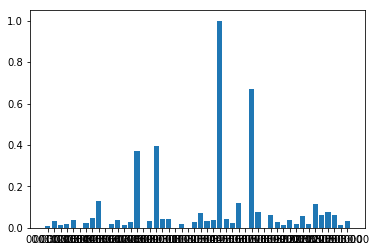

In [48]:
def get_max_time_category(category):
    groups = data.groupby(['category'])
    category = groups.get_group(category)
    time_grpr = category.groupby(pd.Grouper(key='created_at', freq='30min'))
    count_grpr = time_grpr['text'].count()
    sum_grpr = time_grpr['popularity'].sum()
    popularity = sum_grpr/count_grpr
    popularity = (popularity - popularity.min()) / (popularity.max() - popularity.min()) 
    popularity = popularity.fillna(0)
    popularity = popularity.rename('popularity')
    popularity_df = popularity.to_frame()
    popularity_df['tmpstmp'] = popularity.index
    popularity_df['tmpstmp'] = popularity_df['tmpstmp'].dt.time.astype(str)
    plt.bar(popularity_df['tmpstmp'],height = popularity_df['popularity'])
    max_time = popularity_df['popularity'].idxmax()
    return max_time

#Example: the user inputs 'Politics' as the category of their tweet
get_max_time_category('Politics')

### User Specific

In order to analyze the user specific data that we collected from the webscraping, we had to process the data in such a way that we could gage the popularity of a tweet. To do this, we used the same scale to measure the popularity of a tweet as we did in the previous section for the the global tweets. For a specific user, we analyzed all of the posts that the user had on his or her timeline. Using this data, we are able to measure when their posts had the highest percentage of active engagment with his or her followers. Thus, using Pandas, we are able to complete a time series analysis to better understand which 10 minute interval during a 24 hour period should the user post to ensure the highest percentage of engagement. Through this analysis and the data we have collected, we are able to identify a 10 minute interval of when the user's tweets had the highest percentage of engagement with their followers. As an example, we have demonstrated if the user's username was 'elonmusk', we would be able to demonstrate when his tweets have historically had the highest percentage of engagement with his followers.

In [36]:
consumer_key = "jKh08dfgDeTPztN1rzCpTG7Ub"
consumer_secret = "piCHq08QogdkccQjQ4w74ejfNZl0ZLJeN5QDfkyNKp1AUG1nL8"
access_token = "968209315285946373-kB1go0AZDLjgR3uw8D04fkekvLNGrM2"
access_secret = "49zXLZmjYPdVwIufciUGgM5vtn9YtLD4YehU6pydKCWZY"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
user = api.get_user(user_name)
follower_count = user.followers_count

In [73]:
user_timeline_df['created_at'] = user_timeline_df['created_at'].astype(str)
user_timeline_df['created_at'] = pd.DatetimeIndex(user_timeline_df['created_at'])
user_timeline_df['created_at'] = user_timeline_df['created_at'].dt.time.astype(str)
user_timeline_df['created_at'] = pd.DatetimeIndex(user_timeline_df['created_at'])
user_timeline_df['popularity'] = (user_timeline_df['favorite_count'] + user_timeline_df['retweet_count'])/follower_count
user_timeline_df['popularity'] = (user_timeline_df['popularity'] - user_timeline_df['popularity'].min()) / (user_timeline_df['popularity'].max() - user_timeline_df['popularity'].min())

,created_at,text,favorite_count,retweet_count,hashtags,mentions,emojis,popularity
0,2019-12-11 10:15:00,"[tesla, virtual, power, plant, rescue, grid, a...",7109,981,[],[],,0.002598
1,2019-12-11 02:09:00,"[capture, nfirmed, 19, flight, space, station,...",20493,1846,[],"[@space_station,]",,0.039697
2,2019-12-11 15:56:00,"[huge, thanks, everyone, ntributed, idea, cybe...",155034,5473,[],[],,0.399427
3,2019-12-11 12:55:00,"[fa, n, 9, land, urse, still, love, droneship,...",52590,5103,[],[],,0.131743
4,2019-12-11 12:19:00,"[speed, solves, everythingpic, twitter, dgylfy...",238258,30474,[],[],,0.681198
5,2019-12-11 20:46:00,"[super, strong, roof, generates, clean, energy...",46017,3877,[],[],,0.111438
6,2019-12-11 09:43:00,"[dragon, solar, array, deployed, way, internat...",19221,2229,[],[@space_station],,0.037382
7,2019-12-11 09:30:00,"[liftoff, pic, twitter, 4w7otmnay1]",39696,5053,[],[],,0.098043
8,2019-12-11 09:14:00,"[webcast, fa, n, 9, launch, livehttps, twitter...",13455,3284,[],[],,0.025117
9,2019-12-11 06:27:00,"[fa, n, 9, launch, dragon, targeted, 12, 29, p...",11331,1458,[],[],,0.014833


In [38]:
def get_max_time_user():
    user_time_grpr = user_timeline_df.groupby(pd.Grouper(key='created_at', freq='10min'))
    user_count_grpr = user_time_grpr['text'].count()
    user_sum_grpr = user_time_grpr['popularity'].sum()
    user_popularity = user_sum_grpr/user_count_grpr
    user_popularity = user_popularity.fillna(0)
    user_popularity = user_popularity.rename('popularity')
    user_popularity_df = user_popularity.to_frame()
    user_popularity_df['tmpstmp'] = user_popularity.index
    user_popularity_df['tmpstmp'] = user_popularity_df['tmpstmp'].dt.time.astype(str)
    plt.bar(user_popularity_df['tmpstmp'],height = user_popularity_df['popularity'])
    user_max_time = user_popularity_df['popularity'].idxmax()
    return user_max_time

#Example: if the user's username was 'elonmusk'
get_max_time_user()

NameError: name 'user_timeline_df' is not defined

## Predicting Popular Keywords and Hashtags

In [75]:
def make_rankings(data, mode):
    ## creating a ranking column
    if mode=="user":
        data['ranking'] = (data['retweet_count'] + data['favorite_count'])
    else:
        data['ranking'] = (data['retweet_count'] + data['favorite_count'])/data['follower_count']
    ## normalising the ranking columns
    x = data[['ranking']].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    data['ranking'] = 100*pd.DataFrame(x_scaled)
    return 
make_rankings(data,"regular")

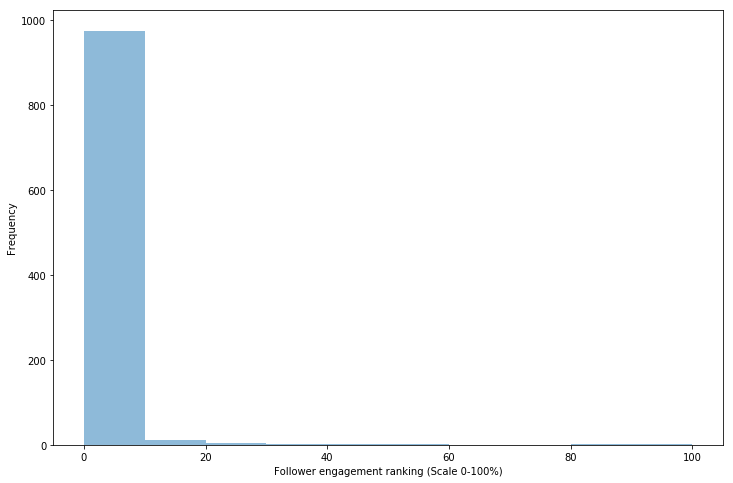

In [76]:
fig = plt.figure(figsize = (12,8))
ax = fig.gca()
ax.set_xlabel("Follower engagement ranking (Scale 0-100%)")
ax.set_ylabel("Number of posts with ranking")
data['ranking'].plot.hist(bins=10, alpha=0.5, ax=ax)

### Time tweet was posted since current day & time
This accounts for the fact that social media trends today are not the same as they were last week or last year. We will calculate the number of days it has been since the tweet was posted

In [77]:
def make_num_seconds(data):
    now = datetime.now()
    diff = []
    data['created_at'] = pd.to_datetime(data['created_at'])
    time_diff = (now - data['created_at'])
    for elem in time_diff:
        diff.append(elem.total_seconds())
    data['num_seconds'] = diff
    return data
data = make_num_seconds(data)

### Similarity between original tweet and tweet in dataframe

In [79]:
def do_nothing(x):
    return x


## comparing tweet_2 to the original tweet written by the user 
def similarity(tweet_2):
    words =[]
    for row in data['text']:
            words.append(list(set(row)))
    tfidf = TfidfVectorizer(tokenizer=do_nothing,preprocessor=do_nothing)
    tfidf.fit(words)
    features_orig = tfidf.transform(original_clean_tweet)
    features_current = tfidf.transform(tweet_2)
    
    cosine = (cosine_similarity(features_orig, features_current))
    cosine_total = 0.0
    for row in cosine:
        cosine_total+= sum(row)

    return cosine_total

similarities = []
for text in data['text']:
    
    similarities.append(similarity(text))
data['similarity'] = similarities
data['similarity'].fillna(0)

0      25.751480
1      26.139657
2      30.778749
3      38.898633
4      19.477091
         ...    
993     9.574866
994    28.898267
995    28.191126
996    34.923147
997    34.018726
Name: similarity, Length: 998, dtype: float64

In [82]:
def find_keywords_hashtags(data):
    keywords = {}
    hashtags = {}
    for index, row in data.iterrows():
        tweet = row["text"]
        for word in tweet:
            if word in keywords:
                keywords[word]+= (row["similarity"]+row["ranking"])/row["num_seconds"]
            else:
                keywords[word] = (row["similarity"]+row["ranking"])/row["num_seconds"]
        for tag in row["hashtags"]:
            if tag in hashtags:
                hashtags[tag] += (row["similarity"]+row["ranking"])/row["num_seconds"]
            else:
                hashtags[tag] = (row["similarity"]+row["ranking"])/row["num_seconds"]

    best_words = {k: v for k, v in sorted(keywords.items(), key=lambda item: item[1], reverse=True)}
    best_tags = {k: v for k, v in sorted(hashtags.items(), key=lambda item: item[1], reverse=True)} 
    
    return best_words, best_tags  

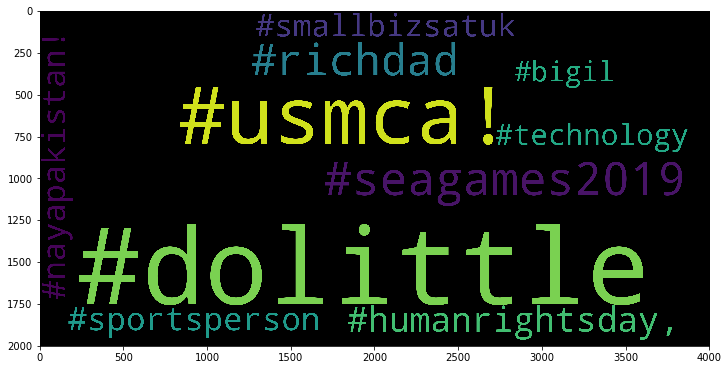

In [83]:
best_keywords, best_hashtags = find_keywords_hashtags(data)
fig = plt.figure(figsize = (12,8))
wc = WordCloud(background_color="black",width=4000,height=2000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(best_hashtags)
plt.imshow(wc)

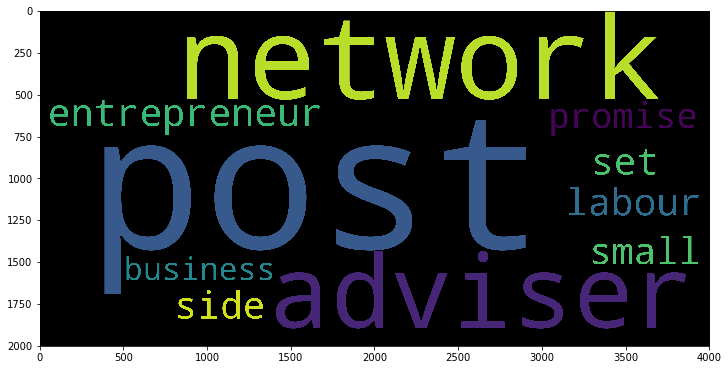

In [84]:
fig = plt.figure(figsize = (12,8))
wc = WordCloud(background_color="black",width=4000,height=2000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(best_keywords)
plt.imshow(wc)

### Providing Keyword and Hashtag Suggestions Based on the User's Timeline

In [85]:
user_timeline_df['created_at'] = pd.to_datetime(user_timeline_df ['created_at'])
similarities = []
for text in user_timeline_df['text']:
    similarities.append(similarity(text))
user_timeline_df['similarity'] = similarities
user_timeline_df['similarity'].fillna(0)
make_num_seconds(user_timeline_df)
make_rankings(user_timeline_df, "user")
best_keywords, best_hashtags = find_keywords_hashtags(user_timeline_df)
print(best_keywords, best_hashtags)

{'cybertruck': 0.12102149301396595, 'breathing': 0.0983313209040832, 'oxygen': 0.0983313209040832, 'everyone': 0.08928875436034944, '21': 0.0808983991056581, 'better': 0.05903679881043875, 'huge': 0.05755601570673293, 'thanks': 0.05755601570673293, 'ntributed': 0.05755601570673293, 'idea': 0.05755601570673293, 'people': 0.05651213523967731, '2': 0.055212510538434775, '1': 0.054757204767507055, 'often': 0.0491656604520416, 'think': 0.0491656604520416, 'theyre': 0.0491656604520416, 'actually': 0.0491656604520416, 'nitrogen': 0.0491656604520416, '78': 0.0491656604520416, 'side': 0.0491656604520416, 'serving': 0.0491656604520416, 'argon': 0.0491656604520416, 'sauce': 0.0491656604520416, 'spiced': 0.0491656604520416, 'h2o': 0.0491656604520416, 'dash': 0.0491656604520416, 'neon': 0.0491656604520416, 'krypton': 0.0491656604520416, 'etc': 0.0491656604520416, 'twitter': 0.046248304557022835, 'november': 0.031732738653616505, '2019': 0.031732738653616505, 'elonmusk': 0.031732738653616505, 'unvei

## Sentiment Analysis

In [50]:
def fetch_sentiment(text):
    analysis = TextBlob(text)
    print(analysis.sentiment)
    if analysis.sentiment.polarity >= 0:
        return 'positive'
    else:
        return 'negative'
    
fetch_sentiment(orig_tweet)

Sentiment(polarity=0.4083333333333334, subjectivity=0.5333333333333333)


'positive'

## Results

Now that we have explored all of the features of our project, here are the final results of our project. In order to demonstrate how all of the features of our project work together, we have created an example input to demonstrate a sample response that our project would give. 

For our example, our user is Elon Musk and his username is 'elonmusk' and he is looking to post this tweet: 'Huge thanks to everyone who contributed ideas to Cybertruck. It’s better because of you! ♥️♥️♥️ #Tesla #Tech2020 #Design'. He has also indicated that the tweet that the category of his tweet is 'Technology'.

To begin, our application will gather the data from the user's timeline and will gather data regarding the tweets in the given category.

In [ ]:
create_timeline_df(user_name)
get_tweets()

First, our application will provide the best times to post. Our application will provide the best time for tweets with 'Technology'-related content to be posted. Additionally, our application will provide the best time for Elon Musk's tweets to be posted

Timestamp('2019-12-11 16:00:00', freq='30T')

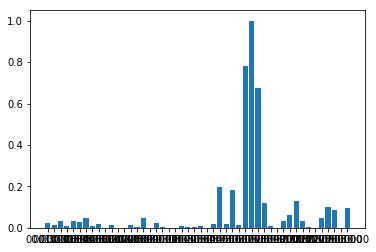

In [49]:
get_max_time_category('Technology')

In [ ]:
get_max_time_user()

Next, our application will provide the user with suggestions on hashtags and keywords that have been included in popular tweets.

Finally, our application will provide the user with the sentiment of the tweet that they intend on posting.

In [ ]:
fetch_sentiment(orig_tweet)

Thus, we have provided four suggestions regarding important factors that a user should consider before posting their tweet. With our application, the user should get much higher social media engagment on each of their tweets if they take our suggestions into consideration. With these suggestions, the user can now identify the best time to post their tweets regarding the category of the content of their tweet, what keywords or hashtags to include, and if the sentiment of their tweet is the same as the sentiment that they are aiming to express.

## Suggestions for Future Research

With more resources and access to data, we would look to actually test our application to ensure that our suggestions can actually improve social media engagement on a user's tweets. Additionally, we would suggest expanding our application to other social media platforms such as Instagram, Facebook, LinkedIn, and etc. We would also suggest expanding our application to analyze the content of images included in a social media post.

For additional references and details, here is the documentation for the important modules that were used in this project:
- Tweepy: [https://www.tweepy.org/](https://www.tweepy.org/)
- Selenium: [https://selenium-python.readthedocs.io/](https://selenium-python.readthedocs.io/)
- Pandas: [https://pandas.pydata.org/](https://pandas.pydata.org/)
- sklearn: [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)
- TextBlob: [https://textblob.readthedocs.io/en/dev/](https://textblob.readthedocs.io/en/dev/)